# ESG - reports

The future of finance goes hand in hand with social responsibility, environmental stewardship and corporate ethics. In order to stay competitive, Financial Services Institutions (FSI)  are increasingly  disclosing more information about their **environmental, social and governance** (ESG) performance. By better understanding and quantifying the sustainability and societal impact of any investment in a company or business, FSIs can mitigate reputation risk and maintain the trust with both their clients and shareholders. At Databricks, we increasingly hear from our customers that ESG has become a C-suite priority. This is not solely driven by altruism but also by economics: [Higher ESG ratings are generally positively correlated with valuation and profitability while negatively correlated with volatility](https://corpgov.law.harvard.edu/2020/01/14/esg-matters/). In this demo, we offer a novel approach to sustainable finance by combining NLP techniques and graph analytics to extract key strategic ESG initiatives and learn companies' relationships in a global market and their impact to market risk calculations.

---
+ <a href="https://databricks.com/notebooks/esg_notebooks/01_esg_report.html">STAGE1</a>: Using NLP to extract key ESG initiatives PDF reports
+ <a href="https://databricks.com/notebooks/esg_notebooks/02_esg_scoring.html">STAGE2</a>: Introducing a novel approach to ESG scoring using graph analytics
+ <a href="https://databricks.com/notebooks/esg_notebooks/03_esg_market.html">STAGE3</a>: Applying ESG to market risk calculations
---

## Context
Financial services organisations are now facing more and more pressure from their shareholders to disclose more information about their environmental, social and governance strategies. Typically released on their websites on a yearly basis as a form of a PDF document, companies communicate on their key ESG initiatives across multiple themes such as how they value their employees, clients or customers, how they positively contribute back to society or even how they reduce  (or commit to reduce) their carbon emissions. Consumed by third parties agencies (such as [msci](https://www.msci.com/esg-ratings) or [csrhub](https://www.csrhub.com/)), these reports are usually consolidated and benchmarked across industries to create ESG metrics. In this notebook, we would like to programmatically access 40+ ESG reports from top tier financial services institutions and learn key ESG initiatives across different topics

### Dependencies
As reported in below cell, we use multiple 3rd party libraries that must be made available across Spark cluster. **NOTE** The next cell assumes you are running this notebook on a Databricks cluster that does not make use of the ML runtime.  If using an ML runtime, please follow these [alternative steps](https://docs.databricks.com/libraries.html#workspace-library) to load libraries to your environment.

In [3]:
#%sql
#CREATE DATABASE esg_db;

In [4]:
import pkg_resources
for d in pkg_resources.working_set:
     print(d)

zipp 0.6.0
zict 1.0.0
yarl 1.6.3
xgboost 0.90
wrapt 1.11.2
wordcloud 1.8.1
wheel 0.30.0
Werkzeug 1.0.1
websocket-client 0.57.0
webencodings 0.5.1
wcwidth 0.2.5
urllib3 1.25.10
ujson 4.0.2
typing-extensions 3.7.4.3
typed-ast 1.4.1
transformers 3.4.0
traitlets 4.3.3
tqdm 4.48.2
tornado 6.1
torch 1.7.0
toolz 0.11.1
toml 0.10.2
tokenizers 0.9.2
tifffile 2020.9.3
thinc 6.12.1
tf2onnx 1.7.2
tf-estimator-nightly 1.14.0.dev2019060501
textblob 0.15.3
termcolor 1.1.0
tensorflow 2.0.0b1
tensorflow-estimator 2.3.0
tensorboard 2.3.0
tensorboard-plugin-wit 1.7.0
tb-nightly 1.14.0a20190603
tabulate 0.8.7
statsmodels 0.10.2
sqlparse 0.4.1
sqlitedict 1.7.0
SQLAlchemy 1.3.13
spacy 2.0.18
soupsieve 2.0.1
smmap 3.0.4
smart-open 1.9.0
sklearn-pandas 1.7.0
skl2onnx 1.4.9
six 1.15.0
shap 0.34.0
setuptools 41.4.0
sentencepiece 0.1.92
segtok 1.5.10
SecretStorage 3.1.2
seaborn 0.11.0
scipy 1.5.2
scikit-learn 0.22.2.post1
scikit-image 0.17.2
sacremoses 0.0.43
s3transfer 0.3.3
ruamel.yaml 0.16.12
ruamel.yaml.clib

In [5]:
import warnings
import requests
import PyPDF2
import io
import re
import string
import pandas as pd
import numpy as np
import gensim
import spacy
from spacy import displacy
import uuid
import os
import json


import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans

from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.sql import functions as F
from pyspark.sql.functions import udf

import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

warnings.simplefilter("ignore", DeprecationWarning)
# %matplotlib inline

## `STEP1`: Extract ESG reports
In this section, we manually search for publicly available ESG reports from top tier FSIs. As of today, I am not aware of any central repository that would consolidate all these reports across companies and industries, so we have to provide all URLs to download ESG reports from for specific companies. As all PDFs may be of different formats, we have to spend a lot of time consolidating reports into well defined statements, then extracting grammatically valid sentences using `spacy`. Although our dataset is relatively small, loading and executing spacy models is an expensive process. We leverage the `pandasUDF` paradigm to load models only once so that our process can easily scale for a larger collection of ESG documents across all your investments.

In [7]:
esg_urls_rows = [
  ['barclays', 'https://home.barclays/content/dam/home-barclays/documents/citizenship/ESG/Barclays-PLC-ESG-Report-2019.pdf'],
  ['jp morgan chase', 'https://impact.jpmorganchase.com/content/dam/jpmc/jpmorgan-chase-and-co/documents/jpmc-cr-esg-report-2019.pdf'],
  ['morgan stanley', 'https://www.morganstanley.com/pub/content/dam/msdotcom/sustainability/Morgan-Stanley_2019-Sustainability-Report_Final.pdf'],
  ['goldman sachs', 'https://www.goldmansachs.com/what-we-do/sustainable-finance/documents/reports/2019-sustainability-report.pdf'],
  ['hsbc', 'https://www.hsbc.com/-/files/hsbc/our-approach/measuring-our-impact/pdfs/190408-esg-update-april-2019-eng.pdf'],
  ['citi', 'https://www.citigroup.com/citi/about/esg/download/2019/Global-ESG-Report-2019.pdf'],
  ['td bank', 'https://www.td.com/document/PDF/corporateresponsibility/2018-ESG-Report.pdf'],
  ['bank of america', 'https://about.bankofamerica.com/assets/pdf/Bank-of-America-2017-ESG-Performance-Data-Summary.pdf'],
  ['rbc', 'https://www.rbc.com/community-social-impact/_assets-custom/pdf/2019-ESG-Report.PDF'],
  ['macquarie', 'https://www.macquarie.com/assets/macq/investor/reports/2020/sections/Macquarie-Group-FY20-ESG.pdf'],
  ['lloyds', 'https://www.lloydsbankinggroup.com/globalassets/documents/investors/2020/2020feb20_lbg_esg_approach.pdf'],
  ['santander', 'https://www.santander.co.uk/assets/s3fs-public/documents/2019_santander_esg_supplement.pdf'],
  ['bluebay', 'https://www.bluebay.com/globalassets/documents/bluebay-annual-esg-investment-report-2018.pdf'],
  ['lasalle', 'https://www.lasalle.com/documents/ESG_Policy_2019.pdf'],
  ['riverstone', 'https://www.riverstonellc.com/media/1196/riverstone_esg_report.pdf'],
  ['aberdeen standard', 'https://www.standardlifeinvestments.com/RI_Report.pdf'],
  ['apollo', 'https://www.apollo.com/~/media/Files/A/Apollo-V2/documents/apollo-2018-esg-summary-annual-report.pdf'],
  ['bmogan', 'https://www.bmogam.com/gb-en/intermediary/wp-content/uploads/2019/02/cm16148-esg-profile-and-impact-report-2018_v33_digital.pdf'],
  ['vanguard', 'https://personal.vanguard.com/pdf/ISGESG.pdf'],
  ['ruffer', 'https://www.ruffer.co.uk/-/media/Ruffer-Website/Files/Downloads/ESG/2018_Ruffer_report_on_ESG.pdf'],
  ['northern trust', 'https://cdn.northerntrust.com/pws/nt/documents/fact-sheets/mutual-funds/institutional/annual-stewardship-report.pdf'],
  ['hermes investments', 'https://www.hermes-investment.com/ukw/wp-content/uploads/sites/80/2017/09/Hermes-Global-Equities-ESG-Dashboard-Overview_NB.pdf'],
  ['abri capital', 'http://www.abris-capital.com/sites/default/files/Abris%20ESG%20Report%202018.pdf'],
  ['schroders', 'https://www.schroders.com/en/sysglobalassets/digital/insights/2019/pdfs/sustainability/sustainable-investment-report/sustainable-investment-report-q2-2019.pdf'],
  ['lazard', 'https://www.lazardassetmanagement.com/docs/-m0-/54142/LazardESGIntegrationReport_en.pdf'],
  ['credit suisse', 'https://www.credit-suisse.com/pwp/am/downloads/marketing/br_esg_capabilities_uk_csam_en.pdf'],
  ['coller capital', 'https://www.collercapital.com/sites/default/files/Coller%20Capital%20ESG%20Report%202019-Digital%20copy.pdf'],
  ['cinven', 'https://www.cinven.com/media/2086/81-cinven-esg-policy.pdf'],
  ['warburg pircus', 'https://www.warburgpincus.com/content/uploads/2019/07/Warburg-Pincus-ESG-Brochure.pdf'],
  ['exponent', 'https://www.exponentpe.com/sites/default/files/2020-01/Exponent%20ESG%20Report%202018.pdf'],
  ['silverfleet capital', 'https://www.silverfleetcapital.com/media-centre/silverfleet-esg-report-2020.pdf'],
  ['kkr', 'https://www.kkr.com/_files/pdf/KKR_2018_ESG_Impact_and_Citizenship_Report.pdf'],
  ['cerberus', 'https://www.cerberus.com/media/2019/07/Cerberus-2018-ESG-Report_FINAL_WEB.pdf'],
  ['standard chartered', 'https://av.sc.com/corp-en/others/2018-sustainability-summary2.pdf'],
]

# create a Pandas dataframe of ESG report URLs
esg_urls_pd = pd.DataFrame(esg_urls_rows, columns=['company', 'url'])

# we distribute our small collection across our cluster to...
# ...exploit parallelism when downloading / curating information
esg_urls = spark.createDataFrame(esg_urls_pd).repartition(8)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/session.py:714: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  'JavaPackage' object is not callable
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.

In [8]:
@udf('string')
def extract_content(url):
  """
  A simple user define function that, given a url, download PDF text content
  Parse PDF and return plain text version
  """
  try:
    # retrieve PDF binary stream
    response = requests.get(url)
    open_pdf_file = io.BytesIO(response.content)
    pdf = PyPDF2.PdfFileReader(open_pdf_file)  
    # access pdf content
    text = [pdf.getPage(i).extractText() for i in range(0, pdf.getNumPages())]
    # return concatenated content
    return "\n".join(text)
  except:
    return ""
    
# download PDF from ESG reports
esg_articles = esg_urls \
  .withColumn('content', extract_content(F.col('url'))) \
  .filter(F.length(F.col('content')) > 0) \
  .cache()

esg_articles.count()
display(esg_articles)

In [9]:
def remove_non_ascii(text):
  printable = set(string.printable)
  return ''.join(filter(lambda x: x in printable, text))

def not_header(line):
  # as we're consolidating broken lines into paragraphs, we want to make sure not to include headers
  return not line.isupper()

def extract_statements(nlp, text):
  """
  Extracting ESG statements from raw text by removing junk, URLs, etc.
  We group consecutive lines into paragraphs and use spacy to parse sentences.
  """
  
  # remove non ASCII characters
  text = remove_non_ascii(text)
  
  lines = []
  prev = ""
  for line in text.split('\n'):
    # aggregate consecutive lines where text may be broken down
    # only if next line starts with a space or previous does not end with dot.
    if(line.startswith(' ') or not prev.endswith('.')):
        prev = prev + ' ' + line
    else:
        # new paragraph
        lines.append(prev)
        prev = line
        
  # don't forget left-over paragraph
  lines.append(prev)

  # clean paragraphs from extra space, unwanted characters, urls, etc.
  # best effort clean up, consider a more versatile cleaner
  sentences = []
  for line in lines:
    
      # removing header number
      line = re.sub(r'^\s?\d+(.*)$', r'\1', line)
      # removing trailing spaces
      line = line.strip()
      # words may be split between lines, ensure we link them back together
      line = re.sub('\s?-\s?', '-', line)
      # remove space prior to punctuation
      line = re.sub(r'\s?([,:;\.])', r'\1', line)
      # ESG contains a lot of figures that are not relevant to grammatical structure
      line = re.sub(r'\d{5,}', r' ', line)
      # remove mentions of URLs
      line = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', r' ', line)
      # remove multiple spaces
      line = re.sub('\s+', ' ', line)
      
      # split paragraphs into well defined sentences using spacy
      for part in list(nlp(line).sents):
        sentences.append(str(part).strip())

  return sentences


In [10]:
esg_statements_pd = esg_articles.select('company', 'content').toPandas()

In [11]:
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=['ner'])

com.fasterxml.jackson.core.JsonParseException: Unrecognized token 'Collecting': was expecting ('true', 'false' or 'null')
 at [Source: Collecting en_core_web_sm==2.0.0; line: 1, column: 11]

In [12]:
esg_statements_pd['statements'] = esg_statements_pd['content'].apply(lambda x: extract_statements(get_spacy_model, x))

com.fasterxml.jackson.core.JsonParseException: Unrecognized token 'Building': was expecting ('true', 'false' or 'null')
 at [Source: Building wheels for collected packages: en-core-web-sm; line: 1, column: 9]

In [13]:
display(esg_statements_pd)

com.fasterxml.jackson.core.JsonParseException: Unrecognized token 'Building': was expecting ('true', 'false' or 'null')
 at [Source:   Building wheel for en-core-web-sm (setup.py): finished with status 'done'; line: 1, column: 11]

In [ ]:

# @pandas_udf('array<string>', PandasUDFType.SCALAR_ITER)
def extract_statements_udf(content_series_iter):
  """
  as loading a spacy model takes time, we certainly do not want to load model for each record to process
  we load model only once and apply it to each batch of content this executor is responsible for
  """
  
  # load spacy model
  spacy.cli.download("en_core_web_sm")
  nlp = spacy.load("en_core_web_sm", disable=['ner'])
  
  # cleanse and tokenize a batch of PDF content 
  for content_series in content_series_iter:
    yield content_series.map(lambda x: extract_statements(nlp, x))

# *****************************
# apply transformation at scale
# *****************************

esg_statements = esg_articles \
  .withColumn('statements', extract_statements_udf(F.col('content'))) \
  .withColumn('statement', F.explode(F.col('statements'))) \
  .filter(F.length(F.col('statement')) > 100) \
  .select('company', 'statement') \
  .cache()

esg_statements.count()
display(esg_statements)

In [0]:
def tokenize(sentence):
  gen = gensim.utils.simple_preprocess(sentence, deacc=True)
  return ' '.join(gen)

def lemmatize(nlp, text):
  
  # parse sentence using spacy
  doc = nlp(text) 
  
  # convert words into their simplest form (singular, present form, etc.)
  lemma = []
  for token in doc:
      if (token.lemma_ not in ['-PRON-']):
          lemma.append(token.lemma_)
          
  return tokenize(' '.join(lemma))

@pandas_udf('string', PandasUDFType.SCALAR_ITER)
def lemma(content_series_iter):
  """
  as loading a spacy model takes time, we certainly do not want to load model for each record to process
  we load model only once and apply it to each batch of content this executor is responsible for
  """

  # load spacy model
  spacy.cli.download("en_core_web_sm")
  nlp = spacy.load("en_core_web_sm", disable=['ner'])
  
  # lemmatize a batch of text content into sentences
  for content_series in content_series_iter:
    yield content_series.map(lambda x: lemmatize(nlp, x))
    
# *****************************
# apply transformation at scale
# *****************************

esg_lemma = esg_statements \
  .withColumn('lemma', lemma(F.col('statement'))) \
  .select('company', 'statement', 'lemma')

display(esg_lemma)

company statement lemma riverstone Founders Statement DRIVING VALUE THROUGH ESG Since founding Riverstone, we have both been strong believers that responsible investing is not only the right thing to do, but it leads to favorable results over the long run. founder statement drive value through esg since found riverstone we have both be strong believer that responsible investing be not only the right thing to do but it lead to favorable result over the long run riverstone Being a trustworthy, fair and transparent partner to each of our stakeholders builds a strong foundation that enables our rm and portfolio companies to succeed. be trustworthy fair and transparent partner to each of our stakeholder build strong foundation that enable our rm and portfolio company to succeed riverstone For that reason, including environmental, social and governance (ESG) at each stage of our investment and asset management processes has been and remains a priority for Riverstone. for that reason include environmental social and governance esg at each stage of our investment and asset management process have be and remain priority for riverstone riverstone As we continue building the rm, we are pleased to present our inaugural ESG Report which highlights our ESG philosophy, the systems we have in place and our objectives for the future. as we continue build the rm we be pleased to present our inaugural esg report which highlight our esg philosophy the system we have in place and our objective for the future riverstone As one of the worlds largest energy, power and infrastructure investment rms, we have spent two decades evolving our ESG processes to reect best practices that align with our core values. as one of the world large energy power and infrastructure investment rm we have spend two decade evolve our esg process to reect good practice that align with our core value riverstone In this regard, we have formalized our ESG program within our organization and across our portfolio companies with processes that span the entire investment lifecycle. in this regard we have formalize our esg program within our organization and across our portfolio company with process that span the entire investment lifecycle riverstone e purpose of this program is to manage risks, maximize opportunity and ensure stakeholder concerns are addressed, where possible, across numerous key ESG factors including natural resource management, health and safety, community and stakeholder impact, climate change, greenhouse gas emissions and governance, among many others. purpose of this program be to manage risk maximize opportunity and ensure stakeholder concern be address where possible across numerous key esg factor include natural resource management health and safety community and stakeholder impact climate change greenhouse gas emission and governance among many other riverstone We believe this steadfast focus on ESG helps us make well-informed decisions that have a positive impact on our companies and the environments in which they operate, and squarely aligns with the duciary duty we owe to our investors. we believe this steadfast focus on esg help we make well inform decision that have positive impact on our company and the environment in which they operate and squarely align with the duciary duty we owe to our investor riverstone LOOKING AHEAD While we are proud of all the progress that we have made, managing ESG requires continuous focus. look ahead while we be proud of all the progress that we have make manage esg require continuous focus riverstone As we look ahead, we will continue adapting and evolving our ESG practices to reect the dynamic and ever-changing world in which we live. as we look ahead we will continue adapt and evolve our esg practice to reect the dynamic and ever change world in which we live riverstone To us, this report represents an important step forward in our commitment to corporate citizenship and transparency. to we this report represent a

## `STEP2`: Topic modelling
Once cleansed, our dataset only contains well defined ESG statements and therefore easily fits in memory (our corpus is ~ 7,200 large). We convert our collection back to pandas dataframe to use native python and visualisations. A first approach will always be to look at term frequency (and inverse document frequency - see [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)) for ngram analysis. By adding stop words that we know are domain specifics (such as bank, plc, inc.), we can easily see relevant words using simple graph or wordclouds.

In [0]:
esg = esg_lemma.select("company", "statement", "lemma").toPandas()

In [0]:
# context specific keywords not to include in topic modelling
fsi_stop_words = [
  'plc', 'group', 'target',
  'track', 'capital', 'holding',
  'report', 'annualreport',
  'esg', 'bank', 'report',
  'annualreport', 'long', 'make'
]

# add company names as stop words
for fsi in [row[0] for row in esg_urls_rows]:
    for t in fsi.split(' '):
        fsi_stop_words.append(t)

# our list contains all english stop words + companies names + specific keywords
stop_words = text.ENGLISH_STOP_WORDS.union(fsi_stop_words)

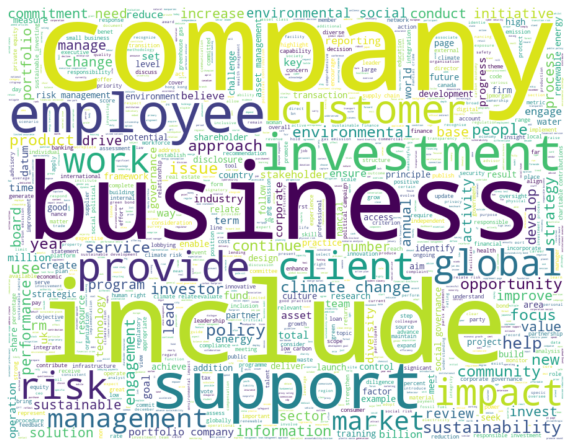

In [0]:
# aggregate all 7200 records into one large string to run wordcloud on term frequency
# we could leverage spark framework for TF analysis and call wordcloud.generate_from_frequencies instead
large_string = ' '.join(esg.lemma)

# use 3rd party lib to compute term freq., apply stop words
word_cloud = WordCloud(
    background_color="white",
    max_words=5000, 
    width=900, 
    height=700, 
    stopwords=stop_words, 
    contour_width=3, 
    contour_color='steelblue'
)

# display our wordcloud across all records
plt.figure(figsize=(10,10))
word_cloud.generate(large_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

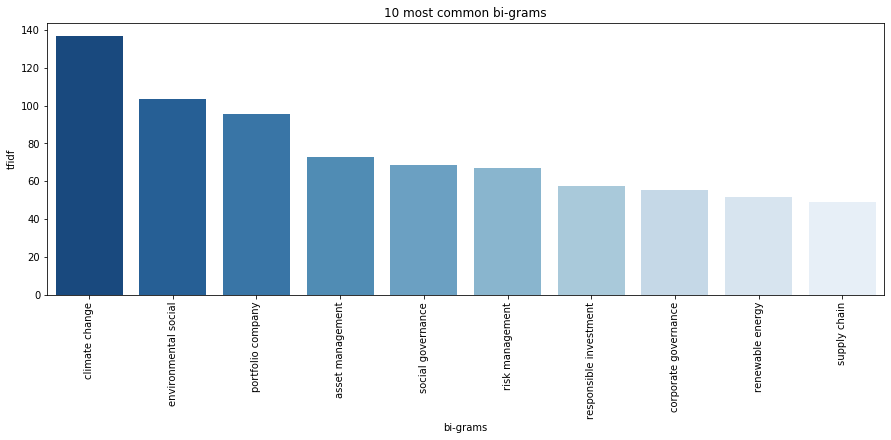

In [0]:
# Run bi-gram TF-IDF frequencies
bigram_tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(2,2), min_df=10, use_idf=True)
bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform(esg.lemma)

# Extract bi-grams names
words = bigram_tf_idf_vectorizer.get_feature_names()

# extract our top 10 ngrams
total_counts = np.zeros(len(words))
for t in bigram_tf_idf:
    total_counts += t.toarray()[0]

count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words)) 

# Plot top 10 ngrams
plt.figure(figsize=(15, 5))
plt.subplot(title='10 most common bi-grams')
sns.barplot(x_pos, counts, palette='Blues_r')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('bi-grams')
plt.ylabel('tfidf')
plt.show()


Using TF-IDF, we can observe a strong focus on "climate change" for most of the organisations. Interestingly, ESG comes hand in hand with risk management as well, our top 4 extracted bigram. We've evaluated multiple approaches using either [non negative matrix factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) or [latent dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation), with TF-IDF and TF respectively. Our experiments indicate 9 topics as descriptive to our corpus documents. We use off the shelf sklearn version of `LatentDirichletAllocation` to learn topics from ESG documents, all topics being described by keywords we can manually sumarize into a specific theme (such as 'valuing employees')

In [0]:
# Compare to NMF, LDA would not require inverse document frequency as it will learn probability distribution of term frequencies
word_tf_vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(1,1))
word_tf = word_tf_vectorizer.fit_transform(esg.lemma)

# serialize stopwords
json_data = json.dumps([a for a in stop_words], indent=2)
f = open("/tmp/stopwords.json", "w")
f.write(json_data)
f.close()
  
# track experiment on MLflow
with mlflow.start_run(run_name='topic_modelling'):
  
  # Train a LDA model with 9 topics
  lda = LDA(random_state = 42, n_components = 9, learning_decay = .3)
  lda.fit(word_tf)
  
  # Log model 
  mlflow.sklearn.log_model(lda, "model")
  mlflow.log_param('n_components', '9')
  mlflow.log_param('learning_decay', '.3')
  mlflow.log_metric('perplexity', lda.perplexity(word_tf))
  mlflow.log_artifact("/tmp/stopwords.json")
  
  # retrieve run ID to attach topic name later
  lda_run_id = mlflow.active_run().info.run_id

In [0]:
# Retrieve top N words describing each of our 9 topics
def top_words(model, feature_names, n_top_words):
  rows = []
  for topic_idx, topic in enumerate(model.components_):
    message = ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    rows.append(["Topic #%d: " % (topic_idx + 1), message])
  return pd.DataFrame(rows, columns=['topic', 'keywords'])

# Display topics keywords for inspection and for us to label topics
tf_feature_names = word_tf_vectorizer.get_feature_names()
display(top_words(lda, tf_feature_names, 15))

topic keywords Topic #1: climate, sustainable, energy, change, green, carbon, bond, renewable, fund, global, company, investment, transition, project, environmental Topic #2: customer, employee, million, business, service, community, client, provide, people, banking, support, help, nancial, product, training Topic #3: business, impact, employee, diversity, support, inclusion, community, diverse, work, drive, people, global, help, time, talent Topic #4: investment, include, financial, investor, global, information, provide, year, industry, nancial, business, equity, public, engagement, market Topic #5: company, supplier, code, good, conduct, party, scale, require, year, score, value, possible, rating, employee, offer Topic #6: human, encourage, people, rights, environment, supply, chain, employee, support, senior, executive, industry, focus, way, future Topic #7: company, social, governance, management, board, environmental, portfolio, annual, performance, policy, information, include, page, reporting, investment Topic #8: risk, investment, management, business, sustainability, client, company, approach, climate, portfolio, team, manage, include, relate, impact Topic #9: emission, company, management, asset, waste, energy, scope, reduce, ghg, environmental, water, reduction, pay, plastic, use

With the description of topics extracted from LDA model, we manually name these as follows. This will be used throughout the rest of the demo as a way to compare organisations based on their ESG statements.

In [0]:
# We estimated our topics to be described around the following themes
topic_names = [
  'company transformation',
  'focus customer',
  'value employees',
  'sustainable finance',
   'code of conduct',
   'support community',
  'strong governance', 
  'ethical investments',
  'green energy'
]

# serialize topic names
json_data = json.dumps(topic_names, indent=2)
f = open("/tmp/topics.json", "w")
f.write(json_data)
f.close()

# attach topics name to LDA model on mlflow
# we do not wish to re-open run_id and therefore alter start / end time
# instead, we log artifact to existing run
client = mlflow.tracking.MlflowClient()
client.log_artifact(lda_run_id, "/tmp/topics.json")

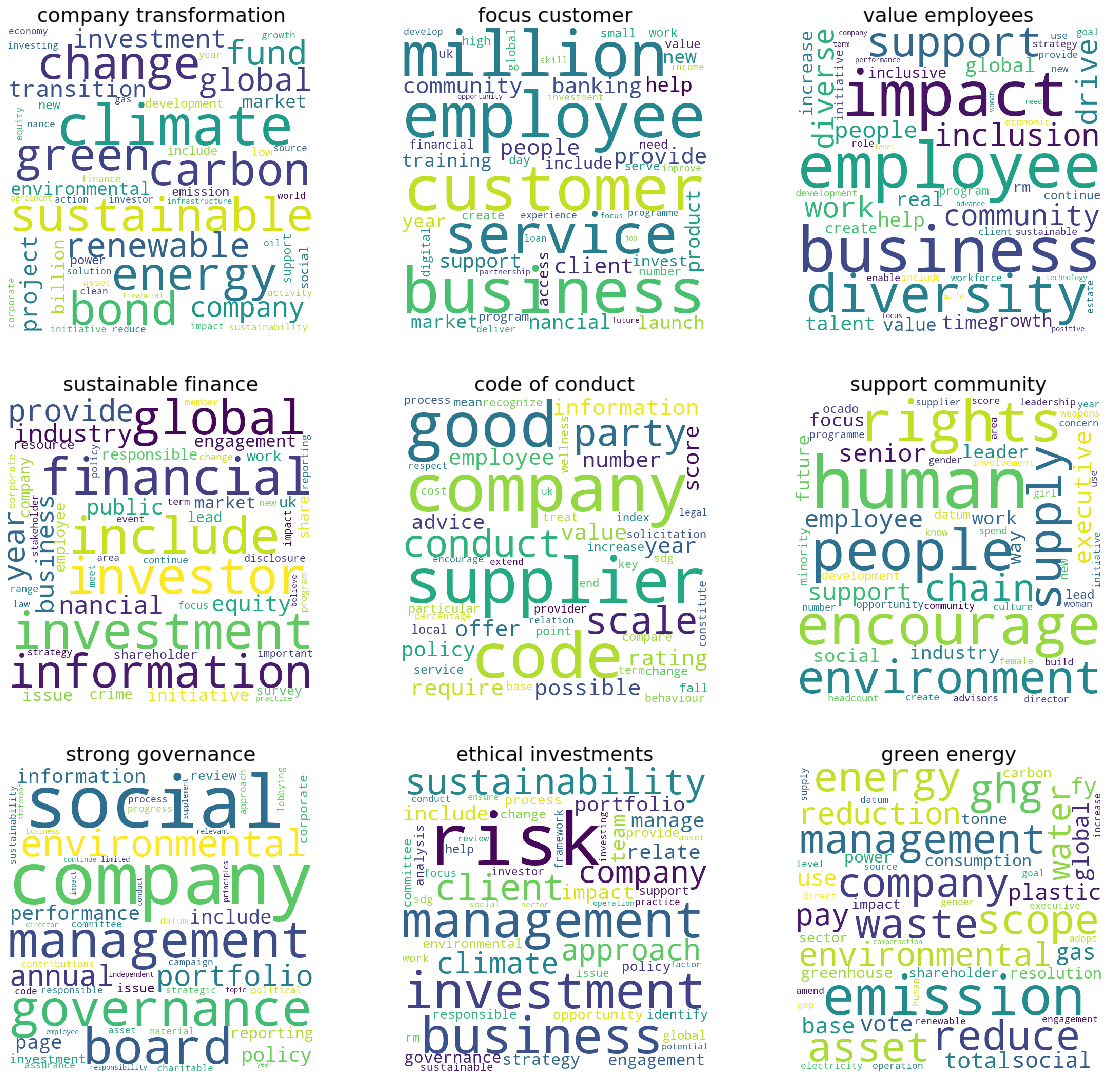

In [0]:
# We ensure relevance of our topics using simple wordcloud visualisation
def word_cloud(model, tf_feature_names, index):
    
    imp_words_topic=""
    comp = model.components_[index]
    vocab_comp = zip(tf_feature_names, comp)
    sorted_words = sorted(vocab_comp, key = lambda x:x[1], reverse=True)[:50]
    
    for word in sorted_words:
        imp_words_topic = imp_words_topic + " " + word[0]
    
    return WordCloud(
        background_color="white",
        width=600, 
        height=600, 
        contour_width=3, 
        contour_color='steelblue'
    ).generate(imp_words_topic)
    
topics = len(lda.components_)
fig = plt.figure(figsize=(20, 20 * topics / 3))

# Display wordcloud for each extracted topic
for i, topic in enumerate(lda.components_):
    ax = fig.add_subplot(topics, 3, i + 1)
    ax.set_title(topic_names[i], fontsize=20)
    wordcloud = word_cloud(lda, tf_feature_names, i)
    ax.imshow(wordcloud)
    ax.axis('off')

In [0]:
# score our original dataset to attach topic distribution to each ESG statement
transformed = lda.transform(word_tf)

# find principal topic from distribution...
a = [topic_names[np.argmax(distribution)] for distribution in transformed]

# ... with associated probability
b = [np.max(distribution) for distribution in transformed]

# consolidate LDA output into a handy dataframe 
df1 = esg[['company', 'lemma', 'statement']]
df2 = pd.DataFrame(zip(a,b,transformed), columns=['topic', 'probability', 'probabilities'])
esg_group = pd.concat([df1, df2], axis=1)

# display dataframe
display(esg_group[['company', 'lemma', 'topic', 'probability']])

company lemma topic probability riverstone founder statement drive value through esg since found riverstone we have both be strong believer that responsible investing be not only the right thing to do but it lead to favorable result over the long run strong governance 0.5002451791625597 riverstone be trustworthy fair and transparent partner to each of our stakeholder build strong foundation that enable our rm and portfolio company to succeed strong governance 0.3922986553248569 riverstone for that reason include environmental social and governance esg at each stage of our investment and asset management process have be and remain priority for riverstone strong governance 0.9315970125370922 riverstone as we continue build the rm we be pleased to present our inaugural esg report which highlight our esg philosophy the system we have in place and our objective for the future support community 0.9258646227965689 riverstone as one of the world large energy power and infrastructure investment rm we have spend two decade evolve our esg process to reect good practice that align with our core value ethical investments 0.5363505983017457 riverstone in this regard we have formalize our esg program within our organization and across our portfolio company with process that span the entire investment lifecycle strong governance 0.9258848791892528 riverstone purpose of this program be to manage risk maximize opportunity and ensure stakeholder concern be address where possible across numerous key esg factor include natural resource management health and safety community and stakeholder impact climate change greenhouse gas emission and governance among many other ethical investments 0.4750372695714395 riverstone we believe this steadfast focus on esg help we make well inform decision that have positive impact on our company and the environment in which they operate and squarely align with the duciary duty we owe to our investor ethical investments 0.5395499913040842 riverstone look ahead while we be proud of all the progress that we have make manage esg require continuous focus strong governance 0.4766089598489574 riverstone as we look ahead we will continue adapt and evolve our esg practice to reect the dynamic and ever change world in which we live sustainable finance 0.5830767905835594 riverstone to we this report represent an important step forward in our commitment to corporate citizenship and transparency sustainable finance 0.9011980456513818 riverstone we hope that you nd it informative and look forward to provide you with additional update in the future sustainable finance 0.6359377989458761 riverstone esg at riverstone integration of esg consideration throughout our operation be core to the long term success of our portfolio company and our rm ethical investments 0.9110907756707219 riverstone about our business found in riverstone be rm focus on energy power and infrastructure company transformation 0.49710757830515895 riverstone who we be since inception riverstone have raise over billion of capital to invest in all major component of our industrys value chain both globally and across the capital structure focus customer 0.4590326588931383 riverstone we be industry expert who provide turnkey investment solution tailor to investor need through our platform of investment strategy private equity credit power infrastructure renewables latin america our philosophy at riverstone innovation and creativity be fundamental tenet that shape the culture we promote both at our portfolio company and within our own organization ethical investments 0.6057783947465218 riverstone we be strong advocate of fresh idea which we believe enable we to always be at the forefront of our industry as leader value employees 0.4742350937862005 riverstone be help we adapt quickly to complex and constantly evolve world to well serve our stakeholder range from investor to employee to community value employees 0.5387228516018776 riverstone from inception to december p

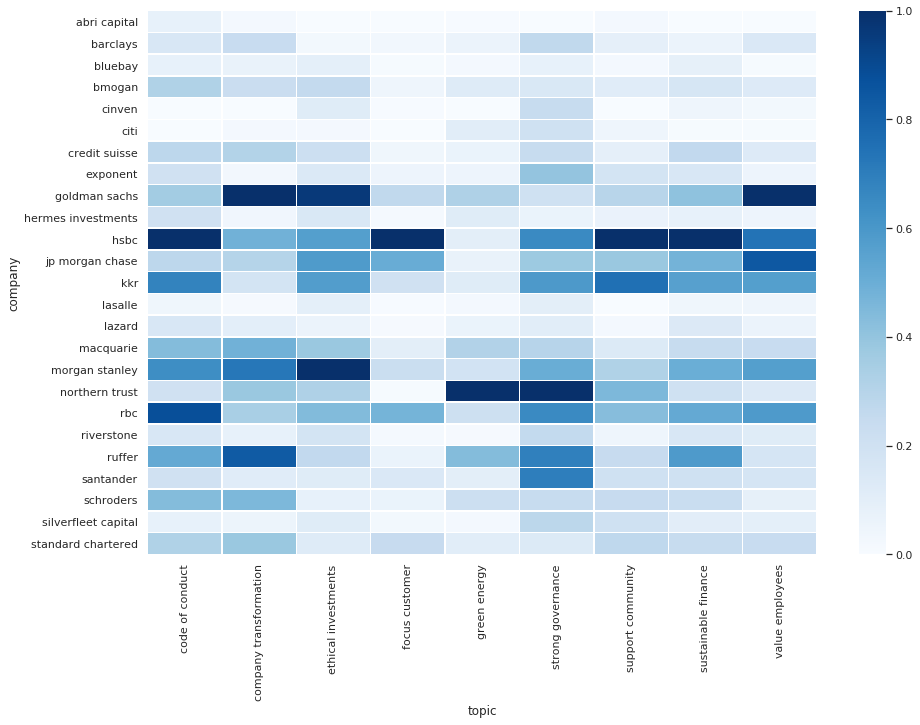

code of conduct company transformation ethical investments focus customer green energy strong governance support community sustainable finance value employees 0.08 0.021739130434782608 0.0 0.0 0.007352941176470588 0.0 0.022727272727272728 0.0 0.0 0.16 0.2391304347826087 0.0267379679144385 0.03470031545741325 0.058823529411764705 0.26771653543307083 0.09090909090909091 0.058823529411764705 0.14655172413793102 0.08 0.07246376811594203 0.0962566844919786 0.00946372239747634 0.022058823529411763 0.07874015748031496 0.022727272727272728 0.08823529411764705 0.008620689655172414 0.32 0.2318840579710145 0.2566844919786096 0.0473186119873817 0.125 0.14960629921259844 0.11363636363636362 0.16666666666666666 0.12931034482758622 0.0 0.0 0.11764705882352941 0.006309148264984227 0.0 0.2440944881889764 0.0 0.049019607843137254 0.02586206896551724 0.0 0.021739130434782608 0.0213903743315508 0.0 0.11029411764705882 0.2047244094488189 0.04545454545454545 0.00980392156862745 0.008620689655172414 0.28 0.3115942028985508 0.2192513368983957 0.04100946372239748 0.0661764705882353 0.2440944881889764 0.09090909090909091 0.2647058823529412 0.12931034482758622 0.2 0.028985507246376812 0.1443850267379679 0.05362776025236593 0.051470588235294115 0.4015748031496063 0.18181818181818182 0.1568627450980392 0.05172413793103448 0.36 1.0 0.9625668449197861 0.26813880126182965 0.3235294117647059 0.2047244094488189 0.29545454545454547 0.4117647058823529 1.0 0.2 0.036231884057971016 0.1497326203208556 0.015772870662460567 0.11764705882352941 0.06299212598425197 0.06818181818181818 0.0784313725490196 0.05172413793103448 1.0 0.48550724637681164 0.5668449197860962 1.0 0.10294117647058823 0.6535433070866141 1.0 1.0 0.7413793103448276 0.28 0.30434782608695654 0.5828877005347594 0.5110410094637223 0.07352941176470588 0.3779527559055118 0.3863636363636364 0.4803921568627451 0.8448275862068966 0.68 0.18115942028985507 0.5775401069518716 0.20189274447949526 0.11764705882352941 0.5905511811023622 0.75 0.5588235294117647 0.5689655172413793 0.04 0.014492753623188404 0.0962566844919786 0.006309148264984227 0.022058823529411763 0.10236220472440945 0.0 0.0392156862745098 0.04310344827586207 0.16 0.10144927536231883 0.0588235294117647 0.012618296529968454 0.0661764705882353 0.11023622047244094 0.022727272727272728 0.13725490196078433 0.06034482758620689 0.44 0.48550724637681164 0.38502673796791437 0.10410094637223974 0.3161764705882353 0.2992125984251969 0.13636363636363635 0.24509803921568626 0.24137931034482757 0.64 0.7246376811594203 1.0 0.22712933753943218 0.19117647058823528 0.5039370078740157 0.31818181818181823 0.5 0.5689655172413793 0.2 0.3840579710144928 0.320855614973262 0.00946372239747634 1.0 1.0 0.4545454545454546 0.20588235294117646 0.13793103448275862 0.88 0.34057971014492755 0.4438502673796791 0.47634069400630913 0.21323529411764705 0.6535433070866141 0.4318181818181819 0.5196078431372549 0.5862068965517241 0.16 0.07971014492753623 0.18181818181818182 0.015772870662460567 0.014705882352941176 0.25984251968503935 0.04545454545454545 0.1568627450980392 0.12068965517241378 0.52 0.8333333333333333 0.26203208556149726 0.06624605678233439 0.4411764705882353 0.6929133858267716 0.24999999999999997 0.5882352941176471 0.1724137931034483 0.2 0.11594202898550725 0.11764705882352941 0.14826498422712933 0.10294117647058823 0.7007874015748031 0.20454545454545456 0.20588235294117646 0.1724137931034483 0.44 0.4565217391304348 0.08021390374331551 0.06309148264984227 0.22058823529411764 0.2440944881889764 0.24999999999999997 0.23529411764705882 0.08620689655172414 0.08 0.057971014492753624 0.11764705882352941 0.025236593059936908 0.022058823529411763 0.28346456692913385 0.20454545454545456 0.10784313725490197 0.09482758620689655 0.32 0.3840579710144928 0.1283422459893048 0.24921135646687698 0.11029411764705882 0.13385826771653542 0.27272727272727276 0.24509803921568626 0.24137931034482757

In [0]:
# create a simple pivot table of number of occurence of each topic across organisations
esg_focus = pd.crosstab(esg_group.company, esg_group.topic)

# scale topic frequency between 0 and 1
scaler = MinMaxScaler(feature_range = (0, 1))

# normalize pivot table
esg_focus_norm = pd.DataFrame(scaler.fit_transform(esg_focus), columns=esg_focus.columns)
esg_focus_norm.index = esg_focus.index

# plot heatmap, showing main area of focus for each FSI across topics we learned
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(esg_focus_norm, annot=False, linewidths=.5, cmap='Blues')
plt.show()

display(esg_focus_norm)

This matrix offers a quick lense through ESG strategies across FSIs. Whilst some companies would focus more on employees and peole (such as Royal Bank of Canada), some such as Goldman Sachs or KKR put a slightly more focus on ethical investments.

In [0]:
# not every statement follows a well defined topic
# some statements may be more generic and span across multiple themes
esg_group.probability.hist(bins=50, figsize=(10,8), color='steelblue')

# plot distribution of main topic proability
plt.axvline(0.89, color='coral', linestyle='--')
plt.title('Primary topic distribution')
plt.xlabel('probability')
plt.ylabel('density')
plt.show()

Only some statements are specific to one distinct topic. Applying threshold of 0.9, we have ~20% of statements that are specific to our topics.
We'll apply this threshold to extract topic specific statements answering questions like *"What actions bank XXX really followed to support local communities?"*

In [0]:
# extract statements relevant to a given topic
topic_discussions = esg_group[esg_group['topic'] == 'value employees']

# as specified in probability distribution, we want only specific topics and not general discussions
topic_discussions = topic_discussions[topic_discussions['probability'] > 0.89]

# access more specific topics first
topic_discussions = topic_discussions.sort_values('probability', ascending=False)

rows = [] 
for i, row in topic_discussions.iterrows():
  rows.append([row.company, row.probability, row.statement])

# display dataframe of statements for selected topic of interest
display(pd.DataFrame(rows, columns=['company', 'probability', 'statement']))

## `STEP3`: Key ESG initiatives
In previous step, we have used a Latent Dirichlet allocation to extract topics from our 7200 large corpus documents. This would return a probability distribution for each statement to cover each of the 9 defined topics. Although this offers a great lense in how we summarize ESG reports programmatically, it does not say much about the specificity of a statement in one organisation compare to others. In other words, we cannot distinguish what are general terms being discussed compare to companies specific ESG strategies. Our goal is to use the probability distribution from LDA as input vector to a superseding clustering algorithm ([KMeans](https://en.wikipedia.org/wiki/K-means_clustering) in that case). By grouping statements into similar buckets, we will be able to access the relevance of a ESG statement with regards to how it deviates from the norm. This approach - similar to anomaly detection - will return the key strategic initiatives for each organisation.

In [0]:
# we extract our probabilities distribution as input vectors for KMeans
X_train = list(esg_group.probabilities)

# nevertheless, we still want to ensure relavance of our clustering using the simple "elbow method"
# we capture the sum of squared distance of each point to their closest center for different values of k
wsses = []
for k in [5, 8, 10, 20, 30, 50, 80, 100]:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(X_train)
  wsse = np.sum([np.min(x)**2 for x in kmeans.transform(X_train)]) 
  wsses.append([k, wsse])
  
# we simply plot the WSSE against K to find optimal K value
wsse_df = pd.DataFrame(wsses, columns=['k', 'wsse'])
display(wsse_df)

This simple methods shows that our ideal number of clusters to group similar statements should be around 15-20.

In [0]:
# track experiment on MLflow
with mlflow.start_run(run_name='clustering'):
  
  # we train our KMeans model trained with the appropriate value for K
  kmeans = KMeans(n_clusters=20, random_state=42)
  kmeans.fit(X_train)
  
  # Log model 
  mlflow.sklearn.log_model(kmeans, "model")
  mlflow.log_param('n_clusters', '15')
  mlflow.log_metric('wsse', np.sum([np.min(x)**2 for x in kmeans.transform(X_train)]))
  
  # Retrieve experiment ID
  cluster_run_id = mlflow.active_run().info.run_id

In [0]:
# find the minimum distance for each point to their closest cluster
y_dist = [np.min(x) for x in kmeans.transform(X_train)]
dist_df = pd.DataFrame(zip(y_dist), columns=['distance'])
esg_group_dist = pd.concat([esg_group, dist_df], axis=1)

In [0]:
#given the cluster distance as relevance of a topic compare to competitors, we
#let that decision to end users to apply industry generic vs. companies specific thresholds via SQL functionalities
spark.createDataFrame(esg_group_dist) \
 .write \
 .format("delta") \
 .saveAsTable("esg_db.reports")

In [0]:
%sql

SELECT 
  t.company,
  t.topic,
  t.statement
FROM (
  SELECT 
    e.company,
    e.topic,
    e.probability,
    e.distance,
    LOWER(e.statement) AS statement,
    dense_rank() OVER (PARTITION BY e.company, e.topic ORDER BY e.distance DESC) as rank
  FROM esg_db.reports e
) t
WHERE t.rank = 1
AND t.topic IN ('green energy')
ORDER BY company, topic, rank

In [0]:
%sql

WITH ranked (
  SELECT 
    e.topic, 
    e.statement, 
    e.company,
    dense_rank() OVER (PARTITION BY e.company, e.topic ORDER BY e.probability DESC) as rank
  FROM esg_db.reports e
)

SELECT 
  t.topic,
  t.statement
FROM ranked t
WHERE t.company = 'goldman sachs' 
AND t.rank = 1

Using NLP techniques to summarize a series of complex PDF documents into key statements and extract key initiatives, we can now provide these insights to asset managers and risk officers as a form of a MI report we later enrich with news analytics data